# ОБРАЗЕЦ РЕЗУЛЬТАТА

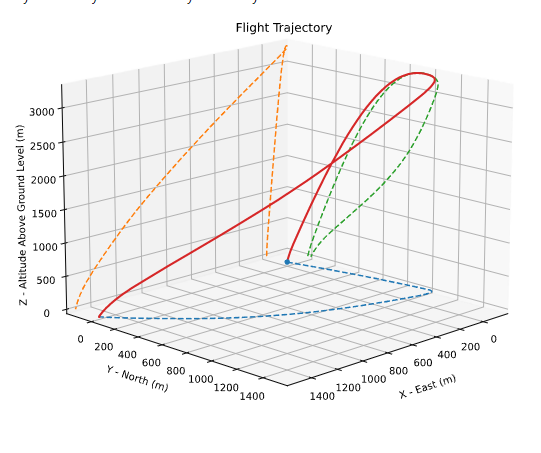

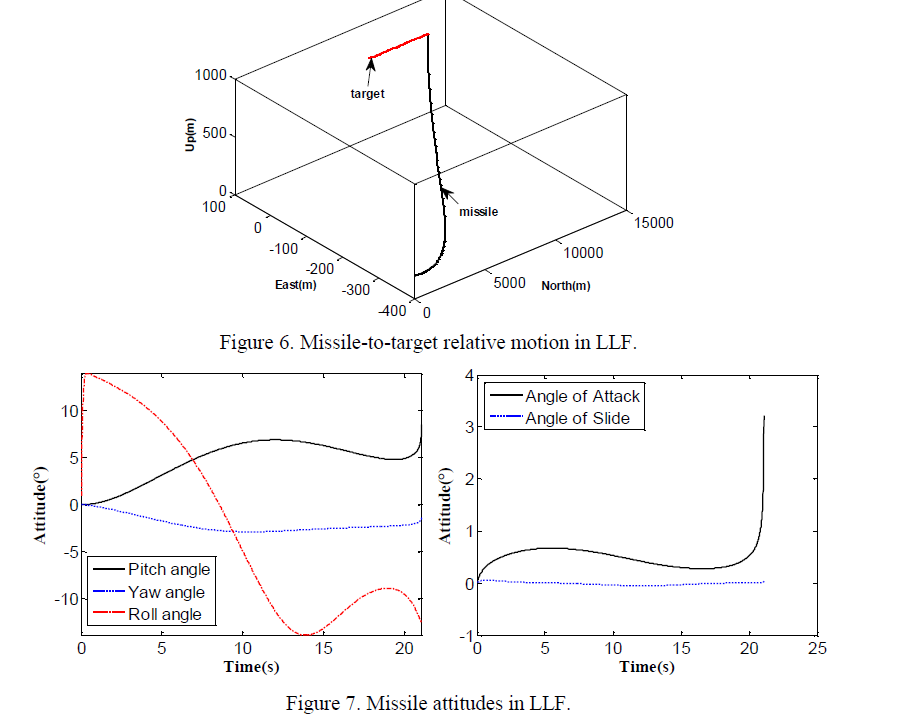

In [1]:
import numpy as np
import numpy.random as rd
from easyvec import Vec3, Mat3
from interpolation import Interp1d, Interp2d
from math import *
from aero_info import *

In [2]:
class Missile3D(object):
    
    @classmethod
    def get_missile(cls, opts):
        """
        Классовый метод создания ракеты со всеми необходимыми аэродинамическими, массо- и тяговременными характеристиками
        
        Arguments
        ---------
        opts : dict 
               словарь с параметрами ракеты
               
        Returns
        -------
        missile : cls
                  экземпляр класса Missile3D
        """
        @np.vectorize
        def get_m(t):
            if t < t_marsh:
                return m_0 - G_marsh * t
            else:
                return m_0 - w_marsh
            
        @np.vectorize
        def get_P(t):
            if t < t_marsh:
                return P_marsh
            else:
                return 0
        
        @np.vectorize
        def get_x_cm(t):
            if t < t_marsh:
                return x_cm_0 - t * (x_cm_0 - x_cm_k) / t_marsh
            else:
                return x_cm_k
        
        @np.vectorize
        def get_x_pres(t):
            if t < t_marsh:
                return x_pres_0 - t * (x_pres_0 - x_pres_k) / t_marsh
            else:
                return x_pres_k
        
        d = opts['d']
        L = opts['L']
        m_0 = opts['m_0']
        v_0 = opts['v_0']
        angle_max = opts['angle_max']
        xi = opts.get('xi', 0.5)
        t_marsh = opts['t_marsh']
        w_marsh = opts['w_marsh']
        P_marsh = opts['P_marsh']
        G_marsh = w_marsh / t_marsh
        am = opts.get('am', 4.5)
        dny = opts.get('dny', 1)
        dnz = opts.get('dnz', 1)
        dnx = opts.get('dnx', 1)
        vel_wind = opts.get('vel_wind', [0,0,0])
        postProcessing = opts.get('record', True)
        
        x_cm_0 = opts['x_cm_0'] / L
        x_cm_k = opts['x_cm_k'] / L
        x_pres_0 = opts['x_pres_0'] / L
        x_pres_k = opts['x_pres_k'] / L
        x_rule = opts['x_rule'] / L
        
        i = opts.get('i', 1.0)
        
        df1 = pd.read_csv('data_constants/cya_from_mach.csv', sep = ";")
        df2 = pd.read_csv('data_constants/cx_from_mach_and_alpha.csv', sep = ";", index_col=0)
        arr_alpha = np.array(df2.index)
        arr_mach = df1['Mach']
        arr_cx = i * df2.to_numpy()
        Cx_itr = Interp2d(arr_alpha, arr_mach, arr_cx)
        
        arr_alpha = opts['alpha']
        arr_mach = opts['Mach']
        arr_delta = opts['delta']
        arr_cy_alpha = opts['Cy_alpha']
        arr_cy_delta = opts['Cy_delta']
        arr_mz_wz = opts['mz_wz'] 
        arr_mx_delta = opts['mx_delta'] 
        arr_mx_wx = opts['mx_wx']          
        
        ts    = np.linspace(0, t_marsh, 100)
        m_itr = Interp1d(ts, get_m(ts))
        P_itr = Interp1d(ts, get_P(ts))
        atm_itr = table_atm
        Cy_alpha_itr = Interp1d(arr_mach, arr_cy_alpha)
        Cy_delta_itr = Interp1d(arr_mach, arr_cy_delta)
        mz_wz_itr = Interp1d(arr_delta, arr_mz_wz)
        mx_delta_itr = Interp1d(arr_delta, arr_mx_delta)
        mx_wx_itr = Interp1d(arr_mach, arr_mx_wx)
        x_pres_itr = Interp1d(ts, get_x_pres(ts))
        x_mass_itr = Interp1d(ts, get_x_cm(ts))
        
        missile = cls(d=d, m_0=m_0, L=L, v_0=v_0,
                      t_marsh=t_marsh, w_marsh=w_marsh, G_marsh=G_marsh,
                      P_itr=P_itr, m_itr=m_itr, atm_itr=atm_itr, vel_wind=vel_wind,
                      x_rule=x_rule, x_mass_itr=x_mass_itr, x_pres_itr=x_pres_itr,
                      Cx_itr=Cx_itr, Cy_alpha_itr=Cy_alpha_itr, Cy_delta_itr=Cy_delta_itr, mz_wz_itr=mz_wz_itr,
                      mx_wx_itr=mx_wx_itr, mx_delta_itr=mx_delta_itr,
                      angle_max=angle_max, xi=xi, am=am, dny=dny, dnz=dnz, dnx=dnx,
                      postProcessing=postProcessing)
        
        return missile
    
    def __init__(self, qw=1, qx=0, qy=0, qz=0, g=9.80665, n=15, **kwargs):
        """
        Конструктор класса Missile3D
        
        Arguments
        ---------
        
        ...
        
        """
        self.g = g
        self.t = 0
        self.n = n
        self.state = np.zeros(self.n)
        self.state_init = np.zeros(self.n)
                
        self.d       = kwargs['d']
        self.L       = kwargs['L']
        self.m_0     = kwargs['m_0']
        self.S_mid   = np.pi * self.d**2 / 4
        self.v       = kwargs['v_0']
        self.v_0     = kwargs['v_0']
        self.xi      = kwargs['xi']
        self.t_marsh = kwargs['t_marsh']
        self.w_marsh = kwargs['w_marsh']
        self.G_marsh = kwargs['G_marsh']
        self.angle_max = kwargs['angle_max']
        self.alpha_targeting = 0
        self.betta_targeting = 0
        self.delta_z = 0
        self.delta_y = 0
        self.P_itr   = kwargs['P_itr']
        self.m_itr   = kwargs['m_itr']
        self.Cx_itr  = kwargs['Cx_itr']
        self.Cy_alpha_itr = kwargs['Cy_alpha_itr']
        self.Cy_delta_itr = kwargs['Cy_delta_itr']
        self.mz_wz_itr = kwargs['mz_wz_itr']
        self.mx_wx_itr = kwargs['mx_wx_itr']
        self.mx_delta_itr = kwargs['mx_delta_itr']
        self.x_rule = kwargs['x_rule']
        self.x_mass_itr = kwargs['x_mass_itr']
        self.x_pres_itr = kwargs['x_pres_itr']
        self.xi = kwargs['xi']
        self.atm_itr = kwargs['atm_itr']
        self.vel_wind = kwargs['vel_wind']
        self.am = kwargs['am']
        self.dny = kwargs['dny']
        self.dnz = kwargs['dnz']
        self.dnx = kwargs['dnx']
        self.postProcessing = kwargs['postProcessing']
        
        self.history = {
            'x': [],
            'y': [],
            'z': [],
            'v_abs': [],
            'vx': [],
            'vy': [],
            'vz': [],
            'wx': [],
            'wy': [],
            'wz': [],
            'qw': [],
            'qx': [],
            'qy': [],
            'qz': [],
            'X': [],
            'Y': [],
            'Z': [],
            'Fx': [],
            'Fy': [],
            'Fz': [],
            'Mx': [],
            'My': [],
            'Mz': [],
            'thetta': [],
            'psi': [],
            'gamma': [],
            'alpha': [],
            'betta': [],
            't': []
        }
        
        # Инициилизация кватерниона 
        if ("scalar" in kwargs) or ("vector" in kwargs):
            # с помощью скалярной и векторной части
            scalar = kwargs.get("scalar", 0.0)
            if scalar is None:
                scalar = 0.0
            else:
                scalar = float(scalar)
            vector = kwargs.get("vector", [])
            vector = self._validate_number_sequence(vector, 3)
            self.qw = scalar
            self.qx, self.qy, self.qz = vector
        elif ("thetta" in kwargs) or ("psi" in kwargs) or ("gamma" in kwargs):
            # с помощью самолетных углов
            thetta = np.radians(kwargs.get("thetta", 0.0))
            psi = np.radians(kwargs.get("psi", 0.0))
            gamma = np.radians(kwargs.get("gamma", 0.0))
            self.qw = np.cos(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
            self.qx = np.cos(thetta/2) * np.cos(psi/2) * np.sin(gamma/2) - np.sin(thetta/2) * np.sin(psi/2) * np.cos(gamma/2)
            self.qy = np.cos(thetta/2) * np.sin(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.cos(psi/2) * np.sin(gamma/2)
            self.qz = np.sin(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) - np.cos(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        elif "array" in kwargs:
            self.qw, self.qx, self.qy, self.qz = self._validate_number_sequence(kwargs["array"], 4)
        else:
            # по умолчанию
            self.qw = qw
            self.qx = qx
            self.qy = qy
            self.qz = qz
        self._normalise_quaternion()
    
    @property
    def rho(self):
        return self.atm_itr(self.state[1], 3)
    
    @property
    def sonic_speed(self):
        return self.atm_itr(self.state[1], 4)
    
    @property
    def G(self):
        return Vec3(0.0, self.m_itr(self.t) * self.g, 0.0)
    
    @property
    def m(self):
        return self.m_itr(self.t)
    
    @property
    def P(self):
        return self.P_itr(self.t)
    
    @property
    def J(self):
        if self.t < self.t_marsh:
            Jx = 1/2 * (self.m_0 - self.G_marsh * self.t) * (self.d/2)**2
            Jy = 1/12 * (self.m_0 - self.G_marsh * self.t) * (self.L)**2
            Jz = 1/12 * (self.m_0 - self.G_marsh * self.t) * (self.L)**2
        else:
            Jx = 1/2 * (self.m_0 - self.w_marsh) * (self.d/2)**2
            Jy = 1/12 * (self.m_0 - self.w_marsh) * (self.L)**2
            Jz = 1/12 * (self.m_0 - self.w_marsh) * (self.L)**2
        return (Jx, Jy, Jz)
    
    @property
    def q_abs(self):
        """
        Текущий скоростной напор набегающего потока воздуха
        
        Returns
        -------
        q : float
        """
        return self.rho * self.vel_abs**2 / 2
    
    @property
    def q(self):
        """
        Вектор текущий скоростной напор набегающего потока воздуха
        
        Returns
        -------
        q : {np.ndarray}
        """
        
        return np.array([self.rho * self.vel[0]**2 / 2, self.rho * self.vel[1]**2 / 2, self.rho * self.vel[2]**2 / 2])
    
    @property
    def mach_abs(self):
        """
        Текущее абсолютное значение числа Маха
        
        Returns
        -------
        M : {float}
        """
        return self.vel_abs / self.sonic_speed
    
    @property
    def mach(self):
        """
        Текущее вектор числа Маха
        
        Returns
        -------
        M : {np.ndarray}
        [Mx, My, Mz]
        [0,   1,  2]
        """
        return np.array(self.vel / self.sonic_speed)
    
    @property
    def quaternion(self):
        """
        Кватернион результируюшего текущего поворота (кватернион как четырехмерный вектор)
        
        Returns
        -------
        quaternion : {np.ndarray}
                     q = [qw, qx, qy, qz] 
                         [ 0,  1,  2,  3]
        """
        return np.array([self.state[9], self.state[10], self.state[11], self.state[12]])
    
    @property
    def norm_quaternion(self):
        """
        Свойство, возвращающее норму кватерниона (длину)
        """
        return np.sqrt(np.dot(self.quaternion, self.quaternion))

    @property
    def thetta(self):
        """
        Угол тангажа ракеты
        """
        return self.get_angle()[0]
    
    @property
    def psi(self):
        """
        Угол курса ракеты
        """
        return self.get_angle()[1]
    
    @property
    def gamma(self):
        """
        Угол крена ракеты
        """
        return self.get_angle()[2]
     
    @property
    def pos(self):
        """
        Пространственный вектор положения ракеты в ГСК
        
        Returns
        -------
        cls Vec3
        [x, y, z] 
        [0, 1, 2]
        """
        return Vec3(self.state[0], self.state[1], self.state[2])
       
    @property
    def vel(self):
        """
        Пространственный вектор скорости ракеты
        
        Returns
        -------
        cls Vec3
        [vx, vy, vz] 
        [0,   1,  2]
        """
        return Vec3(self.state[3], self.state[4], self.state[5])
    
    @property
    def vel_abs(self):
        return np.sqrt(self.vel.dot(self.vel))
    
    @property
    def w(self):
        """
        Пространственный вектор углового вращения ракеты в ССК
        
        Returns
        -------
        cls Vec3
        [wx, wy, wz] 
        [0,   1,  2]
        """
        return Vec3(self.state[6], self.state[7], self.state[8])
    
    def f_system(self, t, y):
        """
        Функция, записывающая правую часть системы ОДУ динамики материального тела в пространстве.
        
        Arguments
        ---------
        t : {float}
            Время в секундах
        y : {np.ndarray / list}
            Вектор состояния системы 
            [0, 1, 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,    13,    14]
            [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, alpha, betta]     
            
        Returns
        -------
        dy : {np.ndarray / list}
             Вектор состояния после дифференцирования системы dy/dt
             [0,   1,  2,  3,  4,  5,    6,    7,    8,   9,  10,  11,  12,     13,     14]
             [vx, vy, vz, ax, ay, az, epsx, epsy, epsz, dqw, dqx, dqy, dqz, dalpha, dbetta]
        """
        x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, alpha, betta = y
        
        delta_alpha = self.alpha_targeting - alpha
        delta_betta = self.betta_targeting - betta
        
        P = self.P_itr(t)
        
        J_x, J_y, J_z = self.J
                       
        # Продольная АД сила
        if self.vel_abs < 1e-5:
            X = 0
        else:
            X = -self.Cx_itr(alpha, self.mach_abs) * self.q_abs * self.S_mid

        # Нормальная АД сила    
        Y = (self.Cy_alpha_itr(self.mach_abs) * alpha * self.q_abs * self.S_mid +\
             self.Cy_delta_itr(self.mach_abs) * delta_alpha * self.q_abs * self.S_mid)
        Z = (self.Cy_alpha_itr(self.mach_abs) * betta * self.q_abs * self.S_mid +\
             self.Cy_delta_itr(self.mach_abs) * delta_betta * self.q_abs * self.S_mid)
        
        # Сумма проекций всех внешних сил на ССК
        Fx = np.linalg.norm(P + X)
        Fy = np.linalg.norm(Y)
        Fz = np.linalg.norm(Z)
        
        # из ССК в ИСК
        F_sum = self._matrix_transition() * Vec3(Fx, Fy, Fz)
        Fx, Fy, Fz = F_sum
        Fy -= np.linalg.norm(self.G)
        
        Mx = 0#(-self.mx_delta_itr(delta_alpha) * delta_alpha * self.q_abs * self.S_mid * self.d -\
             # self.mx_wx_itr(self.mach_abs) * wx * self.q_abs * self.S_mid * self.d**2 / (2 * self.vel_abs)) # Момент косой обувки еще
        My = (self.Cy_alpha_itr(self.mach_abs) * betta * (self.x_mass_itr(t) - self.x_pres_itr(t)) * self.q_abs * self.S_mid * self.L * +\
              self.mz_wz_itr(delta_betta) * self.q_abs * self.S_mid * self.L**2 / self.vel_abs * wy -\
              self.Cy_delta_itr(self.mach_abs) * delta_betta * (self.x_mass_itr(t) - self.x_rule) * self.q_abs * self.S_mid * self.L)
        Mz = (self.Cy_alpha_itr(self.mach_abs) * alpha * (self.x_mass_itr(t) - self.x_pres_itr(t)) * self.q_abs * self.S_mid * self.L +\
              self.mz_wz_itr(delta_alpha) * self.q_abs * self.S_mid * self.L**2 / self.vel_abs * wz -\
              self.Cy_delta_itr(self.mach_abs) * delta_alpha * (self.x_mass_itr(t) - self.x_rule) * self.q_abs * self.S_mid * self.L)
        
        dy = np.zeros(self.n)

        # dr/dt
        dy[0] = vx
        dy[1] = vy
        dy[2] = vz
        
        # dv/dt = a
        dy[3] = Fx / self.m_itr(t)
        dy[4] = Fy / self.m_itr(t)
        dy[5] = Fz / self.m_itr(t)
        
        # domega/dt = eps
        dy[6] = (Mx + (J_y - J_z) * wy * wz) / J_x 
        dy[7] = (My + (J_z - J_x) * wz * wx) / J_y
        dy[8] = (Mz + (J_x - J_y) * wx * wy) / J_z
        
        # dq/dt
        dy[9] = -1/2 * (qx * wx + qy * wy + qz * wz) 
        dy[10] = 1/2 * (qw * wx - qz * wy + qy * wz)
        dy[11] = 1/2 * (qw * wy - qx * wz + qz * wx)
        dy[12] = 1/2 * (qw * wz - qy * wx + qx * wy)
        
        # dalpha/dt
        dy[13] = self.alpha_targeting - alpha
        dy[14] = self.betta_targeting - betta
                        
        return dy
       
    def step(self, action, tau=0.1, n=10):
        """
        Метод моделирования динамики ракеты за шаг по времени tau
        На протяжении tau управляющее воздействие на ракету постоянно (action)
        Шаг интегирования dt определяется из числа разбиения n временного шага tau
        Функция меняет внутреннее состояние ракеты state на момент окончания шага
        
        Arguments
        ---------
        action : {tuple}
                 управляющее воздействие на протяжении шага
        tau    : {float} 
                 длина шага по времени (не путать с шагом интегрирования)
        n      : {int}
                 число шагов разбиений интервала времени tau
            
        Returns
        -------
        None
        """
        self.alpha_targeting = self.angle_max * action[0]
        self.betta_targeting = self.angle_max * action[1]
        
        y = self._validate_y(self.state)
        t = self.state[-1]  
        dt = tau / n
        
        for i in range(n):
            
            k1 = self.f_system(t, y)
            k2 = self.f_system(t + 0.5 * dt, self._validate_y(y + 0.5 * dt * k1))
            k3 = self.f_system(t + 0.5 * dt, self._validate_y(y + 0.5 * dt * k2))
            k4 = self.f_system(t + dt,       self._validate_y(y + dt * k3))
            t += dt
            y  = self._validate_y(y + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
            self.t = t
            self.qw, self.qx, self.qy, self.qz = y[9:13]
            self.state = y
            
            if self.postProcessing:
                self.history['x'].append(y[0])
                self.history['y'].append(y[1])
                self.history['z'].append(y[2])
                self.history['vx'].append(y[3])
                self.history['vy'].append(y[4])
                self.history['vz'].append(y[5])
                self.history['wx'].append(y[6])
                self.history['wy'].append(y[7])
                self.history['wz'].append(y[8])
                self.history['qw'].append(y[9])
                self.history['qx'].append(y[10])
                self.history['qy'].append(y[11])
                self.history['qz'].append(y[12])
                self.history['t'].append(t)
                self.history['v_abs'].append(self.vel_abs)
                self.history['thetta'].append(self.thetta)
                self.history['psi'].append(self.psi)
                self.history['gamma'].append(self.gamma)
                self.history['alpha'].append(self.alpha_targeting)
                self.history['betta'].append(self.betta_targeting)
        
        
    def get_angle(self):
        """
        Метод, вычисляющий самолетные углы Крылова по текущему кватерниону поворота
        
        Returns
        -------
        np.ndarray
        [thetta, psi, gamma]
        """
        C = self._matrix_transition()
        thetta = np.arcsin(C[1][0]) 
        psi = np.arctan2(-C[2][0], C[0][0])
        gamma = np.arctan2(-C[1][2], C[1][1])
        return np.array([thetta, psi, gamma])
    
    def get_initial_parameters_of_missile(self, target):
        """
        Метод, возвращающий начальное состояние ракеты, направленной в упрежденную точку
        
        Arguments:
        ---------
        target : object cls target
        
        Returns
        -------
        np.ndarray [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, alpha, betta]
        """
        meeting_point = np.array(target.pos)
        visir_prevention = meeting_point - self.pos
        thetta = np.arctan2(visir_prevention[1], visir_prevention[0])
        qw, qx, qy, qz = self.get_initial_quaternion(meeting_point)
        return np.array([0, 0, 0, self.v_0 * np.cos(thetta), self.v_0 * np.sin(thetta), 0,
                         0, 0, 0, qw, qx, qy, qz, 0, 0])   
        
    def set_initial_parameters_of_missile(self, target, parameters_of_missile=None):
        """
        Метод, устанавливающий начальные параметры (положение, линейную скорость, угловую скорость, кватернион, время)
        
        Arguments:
        ---------
        target                : object cls target
        parameters_of_missile : list / np.ndarray (default : None)
                                [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, alpha, betta]
        
        Returns
        -------
        None
        """
        if parameters_of_missile is None:    
            parameters_of_missile = self.get_initial_parameters_of_missile(target)
            self.set_initial_quaternion(target.pos)
        self.state = np.array(parameters_of_missile)
        self.state_init = np.array(parameters_of_missile)
    
    def reset(self):
        self.state = self.state_init
    
    def get_line_visir(self, target_pos):
        """
        Метод, вычисляющий линию визирования ракета-цель
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        np.ndarray
        [x, y, z]
        """
        return np.array(target_pos - self.pos)
    
    def get_angle_visir(self, target_pos):
        """
        Метод, вычисляющий углы линии визирования ракета-цель в вертикальной плоскости
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        float
        arctg(y/x)
        """
        visir = self.get_line_visir(target_pos)
        return np.arctan2(visir[1], visir[0])
    
    def get_angle_init(self, target_pos):
        """
        Метод, возвращающий значения углов положения ССК относительно ИСК в начальный момент времени
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        np.ndarray
        [thetta, psi, gamma] в радианах
        """
        return np.array([self.get_angle_visir(target_pos), 0.0, 0.0])
    
    def get_initial_quaternion(self, target_pos):
        """
        Метод, возвращающий значение начального кватерниона поворота ССК в ИСК
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        np.ndarray
        [qw, qx, qy, qz]
        """
        thetta, psi, gamma = self.get_angle_init(target_pos)
        qw = np.cos(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        qx = np.cos(thetta/2) * np.cos(psi/2) * np.sin(gamma/2) - np.sin(thetta/2) * np.sin(psi/2) * np.cos(gamma/2)
        qy = np.cos(thetta/2) * np.sin(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.cos(psi/2) * np.sin(gamma/2)
        qz = np.sin(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) - np.cos(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        norm_quaternion = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
        qw /= norm_quaternion
        qx /= norm_quaternion
        qy /= norm_quaternion
        qz /= norm_quaternion
        return np.array([qw, qx, qy, qz])
    
    def set_initial_quaternion(self, target_pos):
        """
        Метод, устанавливающий значение начального кватерниона поворота ССК в ИСК
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        None
        """
        qw, qx, qy, qz = self.get_initial_quaternion(target_pos)
        self.qw, self.qx, self.qy, self.qz = qw, qx, qy, qz 
        self._normalise_quaternion()
    
    def get_random_action(self, target, integer=False):
        """
        Получить рандомные управляющие воздействия
        
        Arguments
        ---------
        target : object cls Target 

        Returns
        -------
        action : {tuple}
                 [float, float]
        """
        action_alpha = rd.uniform(-1,1)
        action_betta = rd.uniform(-1,1)
        
        if integer == True:
            
            if abs(action_alpha) < 0.5:
                action_alpha = 0.0
            elif action_alpha > 0.5:
                action_alpha = 1.0
            else:
                action_alpha = -1.0
                
            if abs(action_betta) < 0.5:
                action_betta = 0.0
            elif action_betta > 0.5:
                action_betta = 1.0
            else:
                action_betta = -1.0
                
        return (action_alpha, action_betta)
    
    def get_action_proportional_guidance(self, target, am=None):
        """
        Метод, соответствующий методу пропорциональной навигации
        
        Arguments
        ---------
        target : object cls Target 

        Returns
        -------
        action : {tuple}
                 [float, float]
        """
        am  = self.am if am == None else am
        dny = self.dny
        dnz = self.dnz
        
        trg_pos_vertical = np.array(Vec3(target.pos[0], target.pos[1], 0))
        trg_vel_vertical = np.array(target.vel - (Vec3(0,0,1).dot(target.vel) * Vec3(0,0,1)))
        mis_pos_vertical = np.array(Vec3(self.pos[0], self.pos[1], 0))
        mis_vel_vertical = np.array(self.vel - (Vec3(0,0,1).dot(self.vel) * Vec3(0,0,1)))
        
        trg_pos_horizontal = np.array(Vec3(target.pos[0], 0, target.pos[2]))
        trg_vel_horizontal = np.array(target.vel - (Vec3(0,1,0).dot(target.vel) * Vec3(0,1,0)))
        mis_pos_horizontal = np.array(Vec3(self.pos[0], 0, self.pos[2]))
        mis_vel_horizontal = np.array(self.vel - (Vec3(0,1,0).dot(self.vel) * Vec3(0,1,0)))
               
        # Вертикальная плоскость
        vis_vertical = trg_pos_vertical - mis_pos_vertical
        r_vertical = np.linalg.norm(vis_vertical)
        vis1_vertical = vis_vertical / r_vertical
        vel_otn_vertical = trg_vel_vertical - mis_vel_vertical
        vel_otn_tau_vertical = vis1_vertical * np.dot(vis1_vertical, vel_otn_vertical)
        vel_otn_n_vertical = vel_otn_vertical - vel_otn_tau_vertical
        
        # Горизонтальная плоскость
        vis_horizontal = trg_pos_horizontal - mis_pos_horizontal
        r_horizontal = np.linalg.norm(vis_horizontal)
        vel_otn_horizontal = trg_vel_horizontal - mis_vel_horizontal
        vis1_horizontal = vis_horizontal / r_horizontal
        vel_otn_tau_horizontal = vis1_horizontal * np.dot(vis1_horizontal, vel_otn_horizontal)
        vel_otn_n_horizontal = vel_otn_horizontal - vel_otn_tau_horizontal
        
        # Производные углов визирования
        fi_vertical_der = copysign(np.linalg.norm(vel_otn_n_vertical) / r_vertical,
                                   np.cross(vis1_vertical[:-1], vel_otn_n_vertical[:-1]))
        fi_horizontal_der = copysign(np.linalg.norm(vel_otn_n_horizontal) / r_horizontal,
                                     np.cross(vis1_horizontal[:-1], vel_otn_n_horizontal[:-1]))

        # Проивзодные углов наклона ракеты
        thetta_der = am * fi_vertical_der
        psi_der = am * fi_horizontal_der
            
        vel_v_abs = np.linalg.norm(mis_vel_vertical)
        vel_h_abs = np.linalg.norm(mis_vel_horizontal)
        
        nYv = vel_v_abs * thetta_der / self.g + np.cos(self.thetta) + dny
        nYh = vel_h_abs * psi_der / self.g + dnz
        
        m = self.m
        g = self.g
        Cya = self.Cy_alpha_itr(self.mach[0])
        rho = self.rho
        S = self.S_mid
        xi = self.xi
        P = self.P
               
        alpha = ((nYv*m*g) / (Cya*rho*vel_v_abs**2/2*S*(1+xi)+P/57.3))
        betta = ((nYh*m*g) / (Cya*rho*vel_h_abs**2/2*S*(1+xi)+P/57.3))
        
        return (alpha/self.angle_max, betta/self.angle_max)
    
    def to_dict(self):
        return {
            't': self.history['t'],
            'pos': [(self.history['x'][i], self.history['y'][i], self.history['z'][i]) for i in range(len(self.history['t']))],
            'vel': [(self.history['vx'][i], self.history['vy'][i], self.history['vz'][i]) for i in range(len(self.history['t']))],
            'q': [(self.history['qw'][i], self.history['qx'][i], self.history['qy'][i], self.history['qz'][i]) for i in range(len(self.history['x']))],
            'w': [(self.history['wx'][i], self.history['wy'][i], self.history['wz'][i]) for i in range(len(self.history['t']))],
        }
    
    def _validate_number_sequence(self, seq, n):
        if seq is None:
            return np.zeros(n)
        if len(seq) == 0:
            return np.zeros(n)            
        elif len(seq) == n:
            try:
                l = [float(elem) for elem in seq]
            except ValueError:
                raise ValueError("Один или несколько элементов в <{!r}> не действительное(-ые) число(-а)".format(seq))
            else:
                return np.array(l)    
        else:
            raise ValueError("Неожиданное число элементов. Получено: {}, Ожидалось: {}.".format(len(seq), n))      
    
    def _normalise_quaternion(self, tolerance=1e-15):
        """
        Вспомогательный метод, нормализующий кватернион, если он таковым не является
        """
        if abs(1.0 - self.norm_quaternion) > tolerance:
            if self.norm_quaternion > 0:
                self.quaternion = self.quaternion / self.norm_quaternion
        
    def _matrix_transition(self):
        """
        Вспомогательный метод, образующий матрицу перехода от ССК к ИСК из параметров Родрига-Гамильтона
        
        Returns
        -------
        Mat3
        |C11, C12, C13|
        |C21, C22, C23|
        |C31, C32, C33|
        """
        qw, qx, qy, qz = self.quaternion
        C11 = 1 - 2 * (qy**2 + qz**2)
        C12 = 2 * (qx * qy - qw * qz)
        C13 = 2 * (qx * qz + qw * qy)
        C21 = 2 * (qx * qy + qw * qz)
        C22 = 1 - 2 * (qx**2 + qz**2)
        C23 = 2 * (qy * qz - qw * qx)
        C31 = 2 * (qx * qz - qw * qy)
        C32 = 2 * (qy * qz + qw * qx)
        C33 = 1 - 2 * (qx**2 + qy**2)
#         C1 = Vec3(C11, C12, C13)
#         C2 = Vec3(C21, C22, C23)
#         C3 = Vec3(C31, C32, C33)
        return Mat3(C11, C12, C13, C21, C22, C23, C31, C32, C33) # Mat3(*C1, *C2, *C3)
    
    def _validate_y(self, y, tolerance=1e-15):
        """
        Вспомогательный метод проверки заброса углов атаки и скольжения
        """
        # validate alpha
        if y[13] > self.angle_max:
            y[13] = self.angle_max
        elif y[13] < -self.angle_max:
            y[13] = -self.angle_max
        elif abs(y[13] - self.alpha_targeting) < 1e-4:
            y[13] = self.alpha_targeting
        
        # validate betta
        if y[14] > self.angle_max:
            y[14] = self.angle_max
        elif y[14] < -self.angle_max:
            y[14] = -self.angle_max
        elif abs(y[14] - self.betta_targeting) < 1e-4:
            y[14] = self.betta_targeting
            
        # validate quaternion
#         qw, qx, qy, qz = y[9], y[10], y[11], y[12]
#         q_len = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
#         if abs(1.0 - q_len) > tolerance:
#             y[9], y[10], y[11], y[12] = np.array([qw, qx, qy, qz]) / q_len

        return y

# TEST LAUNCH

In [3]:
opts = {
    'd': 0.230,
    'L': 2.89,
    'm_0': 165,
    'v_0': 25,
    't_marsh': 6,
    'w_marsh': 53,
    'P_marsh': 22.5*1e3,
    'angle_max': 10,
    'xi': 0.5,
    'a_m': 5,
    'record': True,
    'x_cm_0': 1.81,
    'x_cm_k': 1.7,
    'x_pres_0': 1.87,
    'x_pres_k': 1.84,
    'x_rule': 0.6,
    'alpha': np.array([-10, -7, -5, -3, -1, 0, 1, 3, 5, 7, 10]),
    'Mach': np.array([0.3, 0.6, 0.9, 1, 1.1, 1.4, 1.7, 2.0, 2.3]),
    'delta': np.array([-15, 0, 15]),
    'Cy_alpha': np.array([0.2, 0.3, 0.35, 0.4, 0.35, 0.3, 0.25, 0.225, 0.2]),
    'Cy_delta': np.array([0.15, 0.25, 0.30, 0.35, 0.30, 0.25, 0.20, 0.175, 0.15]),
    'mz_wz': np.array([-10, 0, 10]),
    'mx_wx': np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]),
    'mx_delta': np.array([1.0, 0, -1.0]),
    'i': 1.0
}

In [4]:
mis = Missile3D.get_missile(opts)

In [5]:
mis._matrix_transition() * Vec3(25, 0, 0)

Vec3(25.0, 0.0, 0.0)

In [6]:
from Target3D import Target3D
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
trg = Target3D.get_simple_target(pos=Vec3(15e3, 10e3, 0.0),
                                 vel=Vec3(-100, 100, 100),
                                 aim=Vec3(100, 0, 100),
                                 vel_aim=Vec3(-150, -150, -100),
                                 time_min=False)
mis.set_initial_parameters_of_missile(trg)
trg.fly_time

81.08920081438177

In [8]:
mis.get_initial_parameters_of_missile(trg)

array([ 0.        ,  0.        ,  0.        , 20.80125736, 13.86750491,
        0.        ,  0.        ,  0.        ,  0.        ,  0.95709203,
        0.        ,  0.        ,  0.28978415,  0.        ,  0.        ])

In [9]:
mis._matrix_transition() * Vec3(1, 0, 0)

Vec3(0.8320502943378437, 0.554700196225229, 0.0)

In [11]:
traj = trg.get_traject(trg.fly_time)

In [12]:
dt = 0.5

In [13]:
for i in tqdm(range(30)):
    trg.step(tau=dt)
    mis.step(mis.get_action_proportional_guidance(trg), tau=dt)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:20<00:00,  2.67s/it]


In [14]:
trg.pos

Vec3(14678.146526003535, 10254.19622711154, 289.30160167769213)

In [15]:
%matplotlib inline

In [16]:
res_trg = trg.to_dict()

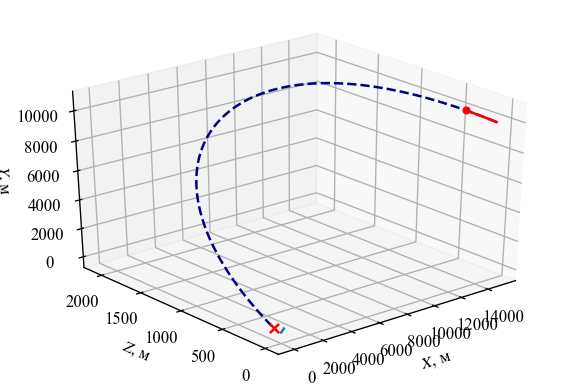

In [17]:
fig = plt.figure(dpi=120)
ax = plt.axes(projection='3d')
ax.plot(traj[:,0], traj[:,2], traj[:,1], ls='--', color='darkblue')
ax.plot(mis.history['x'], mis.history['z'], mis.history['y'])
ax.plot(res_trg['x'], res_trg['z'], res_trg['y'], color='red')
ax.scatter(res_trg['x'][-1], res_trg['z'][-1], res_trg['y'][-1],  marker='o', color='red', s=15)
ax.scatter(traj[:,0][-1], traj[:,2][-1], traj[:,1][-1], marker='x', color='red', s=30)
ax.set_xlabel('$X$, м')
ax.set_ylabel('$Z$, м')
ax.set_zlabel('$Y$, м')
ax.view_init(elev=30, azim=-130)
plt.show()

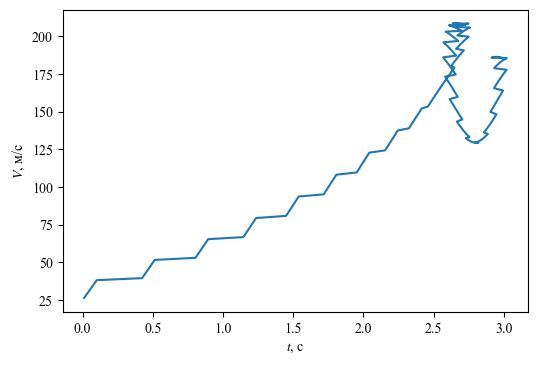

In [18]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], np.sqrt(np.array(mis.history['vx'])**2+np.array(mis.history['vy'])**2+np.array(mis.history['vz'])**2))
plt.xlabel('$t$, c')
plt.ylabel('$V$, м/c')
plt.show()

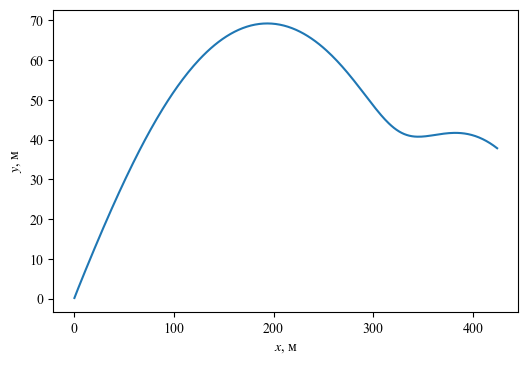

In [19]:
plt.figure(dpi=100)
plt.plot(mis.history['x'], mis.history['y'])
plt.xlabel('$x$, м')
plt.ylabel('$y$, м')
plt.show()

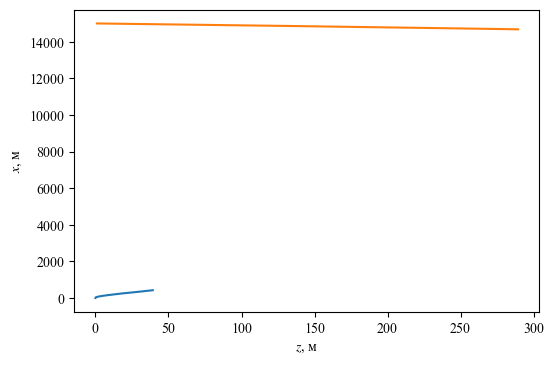

In [20]:
plt.figure(dpi=100)
plt.plot(mis.history['z'], mis.history['x'])
plt.plot(res_trg['z'], res_trg['x'])
plt.xlabel('$z$, м')
plt.ylabel('$x$, м')
plt.show()

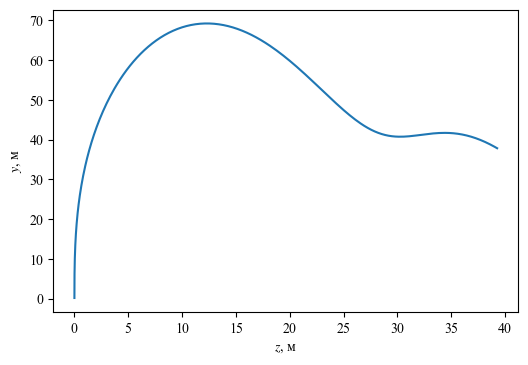

In [21]:
plt.figure(dpi=100)
plt.plot(mis.history['z'], mis.history['y'])
plt.xlabel('$z$, м')
plt.ylabel('$y$, м')
plt.show()

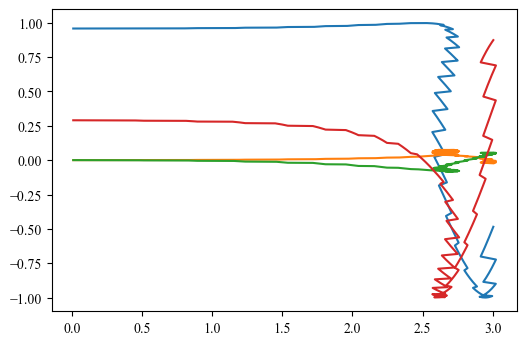

In [22]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['qw'])
plt.plot(mis.history['t'], mis.history['qx'])
plt.plot(mis.history['t'], mis.history['qy'])
plt.plot(mis.history['t'], mis.history['qz'])
plt.show()

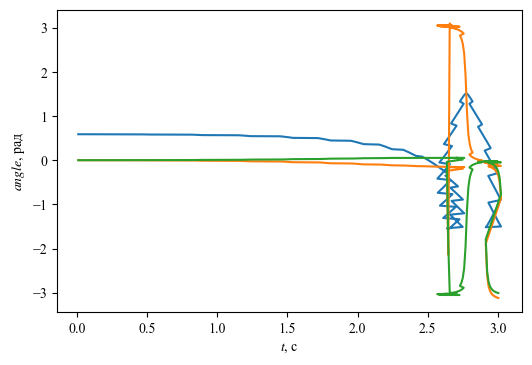

In [23]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['thetta'])
plt.plot(mis.history['t'], mis.history['psi'])
plt.plot(mis.history['t'], mis.history['gamma'])
plt.xlabel('$t$, c')
plt.ylabel('$angle$, рад')
plt.show()

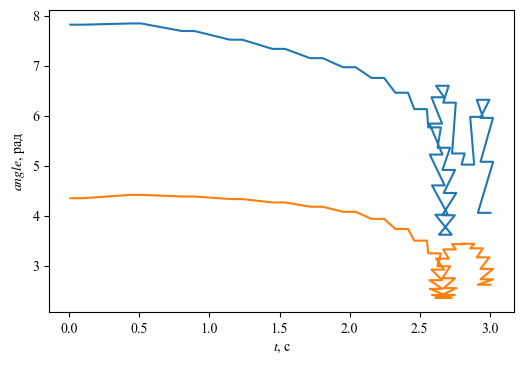

In [24]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['alpha'])
plt.plot(mis.history['t'], mis.history['betta'])
plt.xlabel('$t$, c')
plt.ylabel('$angle$, рад')
plt.show()